pySpark setup
Installing PySpark in colab

In [ ]:
!pip install pyspark
# Installing the PyDrive
!pip install -U -q PyDrive
# Installing java 8 
!apt install openjdk-8-jdk-headless -qq
# Setting the environment variable "JAVA_HOME". This installs the compiler in the required directory.
import os
os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
openjdk-8-jdk-headless is already the newest version (8u342-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth= GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



/bin/bash: pip install -U -q PyDrive: command not found


Importing the file to work on from Google Drive

In [ ]:
fileDownloaded= drive.CreateFile({'id': "17mjMe3V0UbDNG_lC4Se2hE6j4qGvqTit"})
fileDownloaded.GetContentFile('mini_spark_event_data.json')

In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import ArrayType, BooleanType, LongType, FloatType, IntegerType
from pyspark.sql.functions import lit, udf, struct, countDistinct, collect_list, avg, count, col
from pyspark.ml.feature import VectorAssembler, Normalizer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder



In [ ]:
#create a spark session
spark = SparkSession \
         .builder \
         .appName('Mouparna_Assgn4') \
         .getOrCreate()

In [ ]:
#loading the dataset

df = "mini_spark_event_data.json"
df = spark.read.json(df)

In [ ]:
#Cleaning the Dataset
df = df.drop(*['artist','song','firstName', 'lastName', 'id_copy'])             # dropping some irrelevant columns
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])                   # droppping some potential NA values
df = df.filter(df.userId!='').orderBy(["userId", "ts"], ascending=[True, True]) # filtering out the invalid Ids
df = df.withColumn("userId", df["userId"].cast(IntegerType()))

In [ ]:
# Defining the Churn
# These are Customers landing on the Cancellation Confirmation page
cancelation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, 
                  IntegerType())  
df = df.withColumn("churn", cancelation("page"))
window = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, 
                                                   Window.unboundedFollowing)
df = df.withColumn("churn", Fsum("churn").over(window))

In [ ]:
##Some new columns were made in this step to make the data exploration easier,
# the Feature engineering step comes later
# Making the level_shift Column
# This column tells us how many times did the customer switched
# from paid to free service
window1 = Window.partitionBy().orderBy(["userId", "ts"])
df = df.withColumn("level_shift", (df.level!=F.lag(df.level).over(window1)) | 
                   (df.userId!=F.lag(df.userId).over(window1)))
df=df.fillna({'level_shift':0})
df= df.withColumn("level_shift", F.when(df["level_shift"]==False, 0).otherwise(1))

In [ ]:
# Making the last_ts column
# This column will help us to select only records that happened in the
# last 2 weeks of customer activity
# The idea is that customer behavior should be different shortly before
# the churn happened
df= df.withColumn("ts", df.ts/1000)                        # trimming the last three zeros from the UNIX time (miliseconds)
df= df.withColumn("registration", df.registration/1000)

In [ ]:
window2 = Window.partitionBy("userId")
df= df.withColumn("last_ts", F.max('ts').over(window2))
df=df.filter(df.last_ts - df.ts < 1300000) # approx no of sec in a 2 weeks

In [ ]:
# Making the Columns: pages_per_session, diff_time
# pages_per_session is number of pages per session
# diff_time is a number of days since a specific page was visited
window3 = Window.partitionBy(["userId", "sessionId"])
df= df.withColumn("pages_per_session", F.max('ItemInSession').over(window3))
df = df.withColumn("ts_time",F.to_timestamp(df.ts))                    #  unix to datetime
df = df.withColumn("last_ts_time",F.to_timestamp(df.last_ts))          # unix to datetime

In [ ]:
df = df.withColumn("diff_time",F.datediff(df.last_ts_time, df.ts_time))  # how many days ago was the page visited
df=df.orderBy(["userId", "ts"], ascending=[True, True])
df.createOrReplaceTempView('data');                                    # Create a Temp Table to be used for SQL queries

In [ ]:
#Data Preview
df.limit(2).toPandas()

,auth,gender,itemInSession,length,level,location,method,page,registration,sessionId,...,ts,userAgent,userId,churn,level_shift,last_ts,pages_per_session,ts_time,last_ts_time,diff_time
0,Logged In,F,0,250.82730,paid,"Raleigh, NC",PUT,NextSong,1.536800e+09,1639,...,1.542150e+09,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,0,0,1.542839e+09,192,2018-11-13 22:51:43,2018-11-21 22:30:04,8
1,Logged In,F,1,148.55791,paid,"Raleigh, NC",PUT,NextSong,1.536800e+09,1639,...,1.542150e+09,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",2,0,0,1.542839e+09,192,2018-11-13 22:55:53,2018-11-21 22:30:04,8


In [ ]:
# The column "page" seems to be most informative in the whole dataset
# It shows which pages of the service were visited by users, timestamp is also provided
# This column can be used to engineer useful features
df.select('page','UserId').groupby('page').agg({'page':'count'}).select('page','count(page)').show()

In [ ]:
# Investigation if there are differences between churned and non-churned users
# label             - 0 if non_churned, 1 if churned
# song_count        - avg number of songs played by churned/non_churned users
# error             - avg number of errors occuring 
# friends           - avg number of "friends" on thhe application
# playlist_count    - avg number of visits to the Playlist page
# thumbs_up         - avg number of clicking the 'thumbs up'
# thumbs_down       - avg number of clicking the 'thumbs down'
# downgrade         - avg number of visits to the downgrade page
# count_session_dist- avg number of sessions made
# count_diff_time   - avg number of days (in the last two weeks) in which the user used the app
# pages per session - avg numbers of pages (or any activity or changes) per session
# duration          - avg number of days since the user joined (division with 86400 as a proxy of seconds within a day)
# level_shift       - avg number of level changes (free, paid) per customer
# usage_time        - avg total time spent using the app
stats = spark.sql(" WITH prep as( \
SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
avg(distinct pages_per_session)                                     as pages_per_session, \
(max(ts) - min(registration))/86400                                 as duration, \
sum(level_shift)                                                    as level_shift, \
sum(length)                                                         as usage_time \
FROM data \
GROUP BY userId) \
SELECT label, \
count(label)             as cnt, \
avg(song_count)          as song_count, \
avg(error)               as error, \
avg(friends)             as friends, \
avg(playlist_count)      as playlist_count, \
avg(thumbs_up)           as thumbs_up, \
avg(thumbs_down)         as thumbs_down, \
avg(downgrade)           as downgrade, \
avg(count_session_dist)  as count_session_dist, \
avg(count_diff_time)     as count_diff_time, \
avg(pages_per_session)   as pages_per_session, \
avg(duration)            as duration, \
avg (level_shift)        as level_shift, \
avg(usage_time)          as usage_time \
FROM prep \
GROUP BY label")
# We can see that for most dimensions/features there are differences between
# churned and non-churned users
stats.toPandas()

In [ ]:
# Investigation if there are differences between churned and non-churned users
# label             - 0 if non_churned, 1 if churned
# song_count        - avg number of songs played by churned/non_churned users
# error             - avg number of errors occuring 
# friends           - avg number of "friends" on thhe application
# playlist_count    - avg number of visits to the Playlist page
# thumbs_up         - avg number of clicking the 'thumbs up'
# thumbs_down       - avg number of clicking the 'thumbs down'
# downgrade         - avg number of visits to the downgrade page
# count_session_dist- avg number of sessions made
# count_diff_time   - avg number of days (in the last two weeks) in which the user used the app
# pages per session - avg numbers of pages (or any activity or changes) per session
# duration          - avg number of days since the user joined (division with 86400 as a proxy of seconds within a day)
# level_shift       - avg number of level changes (free, paid) per customer
# usage_time        - avg total time spent using the app
stats = spark.sql(" WITH prep as( \
SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
avg(distinct pages_per_session)                                     as pages_per_session, \
(max(ts) - min(registration))/86400                                 as duration, \
sum(level_shift)                                                    as level_shift, \
sum(length)                                                         as usage_time \
FROM data \
GROUP BY userId) \
SELECT label, \
count(label)             as cnt, \
avg(song_count)          as song_count, \
avg(error)               as error, \
avg(friends)             as friends, \
avg(playlist_count)      as playlist_count, \
avg(thumbs_up)           as thumbs_up, \
avg(thumbs_down)         as thumbs_down, \
avg(downgrade)           as downgrade, \
avg(count_session_dist)  as count_session_dist, \
avg(count_diff_time)     as count_diff_time, \
avg(pages_per_session)   as pages_per_session, \
avg(duration)            as duration, \
avg (level_shift)        as level_shift, \
avg(usage_time)          as usage_time \
FROM prep \
GROUP BY label")
# We can see that for most dimensions/features there are differences between
# churned and non-churned users
stats.toPandas()

In [ ]:
# Feature Enigneering
# Based on the previous analysis, all 14 investigated features will be included. 
# Here I am making a Temp Table which holds all the features.
# The temp table will be used as model input
# All data is aggregated per userId
features = spark.sql("SELECT userId, \
max(churn)                                                          as label, \
count(case when page = 'NextSong' then userId else null end)        as song_count, \
count(case when page = 'Error' then userId else null end)           as error, \
count(case when page = 'Add Friend' then userId else null end)      as friends, \
count(case when page = 'Add to Playlist' then userId else null end) as playlist_count, \
count(case when page = 'Thumbs Up' then userId else null end)       as thumbs_up, \
count(case when page = 'Thumbs Down' then userId else null end)     as thumbs_down, \
count(case when page = 'Downgrade' then userId else null end)       as downgrade, \
count(distinct sessionId)                                           as count_session_dist, \
count(distinct diff_time)                                           as count_diff_time, \
round(avg(distinct pages_per_session),0)                            as pages_per_session, \
round((max(ts) - min(registration))/86400,0)                        as duration, \
round(sum(level_shift),0)                                           as level_shift, \
round(sum(length),0)                                                as usage_time \
FROM data \
GROUP BY userId");
features.createOrReplaceTempView('features');
features=features.na.drop()

In [ ]:
#Train test split
training, test = features.randomSplit([0.8,0.2])

In [ ]:
# Make VectorAssembler - this is a Pypark specific step
# All input features must be in one column before feeding into the model
assembler = VectorAssembler(inputCols=["userId","song_count","error","friends","playlist_count", \
                                       "thumbs_up","thumbs_down","downgrade", "count_session_dist",\
                                       "count_diff_time","pages_per_session", "duration","level_shift",\
                                       "usage_time"], \
                            outputCol="inputFeatures")

In [ ]:
#Normalize Data
scaler = Normalizer(inputCol = "inputFeatures",outputCol="features")

In [ ]:
# Assigning the classifier
lr = LogisticRegression()
gbt = GBTClassifier()
rf = RandomForestClassifier()

In [ ]:
#Building pipelines
pipeline1 = Pipeline(stages=[assembler, scaler,lr])
pipeline2 = Pipeline(stages=[assembler, scaler,gbt])
pipeline3 = Pipeline(stages=[assembler, scaler,rf])

In [ ]:
# metric chosen is f1 (we want to catch true positives (churn customers), but
# we do not want to waste money on false positives (investing in retaining 
# non-churn customers, which are loyal anyway)
# Note that Recall might also be justified to use here (if the cost offalse
# positives is low)
paramgrid =ParamGridBuilder()\
.addGrid(lr.regParam, [0.0, 0,1])\
.addGrid(lr.maxIter, [10])\
.build()

In [ ]:
evaluator = MulticlassClassificationEvaluator(metricName="f1")

In [ ]:
crossval= CrossValidator(estimator=pipeline1,  
                         estimatorParamMaps=paramgrid,
                         evaluator = evaluator , 
                         numFolds=3
                        )

In [ ]:
cvModel1 = crossval.fit(training)

In [ ]:
evaluator.evaluate(cvModel1.transform(test))

Gradient Boosted tree Classifier

In [ ]:
# Specify multiple parameters in the paramgrid, in case you have
# enough processing power 
paramgrid1 =ParamGridBuilder().build()

In [ ]:
evaluator=MulticlassClassificationEvaluator(metricName="f1")

In [ ]:
crossval= CrossValidator(estimator=pipeline2,  
                         estimatorParamMaps=paramgrid1,
                         evaluator=evaluator, 
                         numFolds=3
                        )

In [ ]:
cvModel2 = crossval.fit(training)

In [ ]:
evaluator.evaluate(cvModel2.transform(test))

0.7500864838151717

Random Forest Classifier

In [ ]:
paramgrid2 = ParamGridBuilder().build()

In [ ]:
evaluator=MulticlassClassificationEvaluator(metricName="f1")

In [ ]:
crossval = CrossValidator(estimator=pipeline3,
                          estimatorParamMaps=paramgrid2,
                          evaluator=evaluator,
                          numFolds=3
                          )

In [ ]:
cvModel3 = crossval.fit(training)

In [ ]:
evaluator.evaluate(cvModel3.transform(test))

0.8744360902255641

In [ ]:
predictions=cvModel2.transform(test)

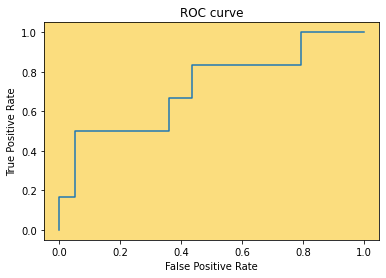

In [ ]:
#Plotting ROC curve
def roc(ax, predictions, labels, title='ROC curve'):
    pp = predictions.toPandas()['probability'].apply(lambda x:x[1]).values
    tpr, fpr, _ = roc_curve(labels, pp)
    ax.plot(tpr, fpr)
    ax.set_facecolor('xkcd:wheat')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    
#plt.clf() # to be used for AWS EMR
labels=predictions.toPandas()['label']
fig = plt.figure()
ax = fig.add_subplot(111)
roc(ax, predictions,labels)